This is the implementation of Visual Transformer

In [1]:
import os
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Try to get torchinfo for model summary
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from PIL import Image

# Input directory containing the original dataset
# The structure should be something like:
# input_dir/class1/*.jpg
# input_dir/class2/*.jpg
# etc.
input_dir = "archive/Training"

# Output directory where augmented images will be saved
output_dir = "archive/Training"
os.makedirs(output_dir, exist_ok=True)

# Number of augmented copies per original image
num_augmentations = 3

# Define your offline augmentation transforms
augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor()  # For processing, but we'll convert back to PIL for saving
])

# Load the original dataset (no transform here, we'll apply augmentation manually)
original_dataset = datasets.ImageFolder(root=input_dir)

# Iterate over all samples in the dataset
for idx, (img_path, class_index) in enumerate(original_dataset.samples):
    # Load the original image
    img = Image.open(img_path).convert("RGB")

    class_name = original_dataset.classes[class_index]
    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    # Original filename without extension
    base_name = os.path.splitext(os.path.basename(img_path))[0]

    # Save the original image as well (optional)
    # If you do not want to save the original image again, you can skip this step.
    original_output_path = os.path.join(class_dir, f"{base_name}.jpg")
    if not os.path.exists(original_output_path):
        img.save(original_output_path, format='JPEG', quality=95)

    # Generate augmented versions and save them
    for i in range(num_augmentations):
        # Apply the transforms (note: some transforms require PIL, so we handle carefully)
        # Since we included transforms.ToTensor() in our augmentation,
        # we need to convert back to PIL after augmentation.
        aug_tensor = augmentation_transform(img)
        
        # Convert the tensor back to PIL Image for saving
        aug_img = transforms.ToPILImage()(aug_tensor)

        # Create a new filename for the augmented image
        aug_output_path = os.path.join(class_dir, f"{base_name}_aug{i+1}.jpg")
        aug_img.save(aug_output_path, format='JPEG', quality=95)

    if idx % 100 == 0:
        print(f"Processed {idx}/{len(original_dataset.samples)} images...")

print("Offline augmentation complete!")


In [2]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

def train_loop(dataloader, model, loss_fn, optimizer, device):
    train_loss = 0
    samples = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item() * len(y)
        samples += len(y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= samples
    return train_loss

def test_loop(dataloader, model, loss_fn, device):
    test_loss = 0
    test_accuracy = 0
    samples = 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)

            loss = loss_fn(pred, y)
            test_loss += loss.item() * len(y)
            _, preds = torch.max(pred, 1)
            test_accuracy += accuracy(y, preds) * len(y)
            samples += len(y)

    test_loss /= samples
    test_accuracy /= samples
    return test_loss, test_accuracy


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
'''
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])'''

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



In [5]:
TRAIN_DIR = 'archive/Training'
TEST_DIR = 'archive/Testing'

# Load the training dataset
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)

# Load the testing dataset
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transform)

classes = train_dataset.classes
print(f"Number of classes: {len(classes)}, Classes: {classes}")
len(train_dataset), len(test_dataset), classes



Number of classes: 4, Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


(2870,
 394,
 ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

In [6]:
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


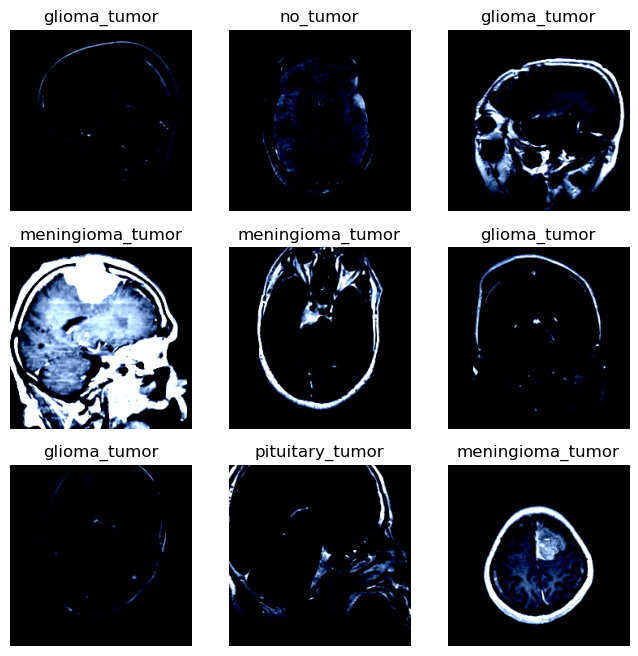

In [7]:
fig = plt.figure(figsize=(8, 8))
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    image, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(classes[label])
    plt.axis('off')
plt.show()


In [8]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Load pre-trained ViT model
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)

# Freeze the encoder layers if desired (optional)
for param in model.encoder.parameters():
    param.requires_grad = True

# Modify the classifier head
num_classes = len(classes)
model.heads = nn.Linear(model.hidden_dim, num_classes)

# Move the model to the appropriate device
model = model.to(device)

# Print the model summary
summary(model, input_size=(1, 3, 224, 224), device=device.type)


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 4]                    768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          590,592
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-7             

In [ ]:
import torch.nn as nn
learning_rate = 0.0001
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [10]:
from tqdm.auto import tqdm

EPOCHS = 30
train_losses = []
test_losses = []
test_accuracies = []
import warnings
warnings.filterwarnings('ignore')

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%\n")


Epoch 1/30
Train Loss: 0.8166 | Test Loss: 0.9808 | Test Accuracy: 78.17%

Epoch 2/30
Train Loss: 0.7195 | Test Loss: 1.0805 | Test Accuracy: 73.86%

Epoch 3/30
Train Loss: 0.7036 | Test Loss: 1.0464 | Test Accuracy: 74.87%

Epoch 4/30
Train Loss: 0.6768 | Test Loss: 1.1234 | Test Accuracy: 73.86%

Epoch 5/30
Train Loss: 0.6811 | Test Loss: 1.0233 | Test Accuracy: 75.63%

Epoch 6/30
Train Loss: 0.6624 | Test Loss: 1.2255 | Test Accuracy: 66.24%

Epoch 7/30
Train Loss: 0.6522 | Test Loss: 1.0211 | Test Accuracy: 77.41%

Epoch 8/30
Train Loss: 0.6495 | Test Loss: 0.9724 | Test Accuracy: 79.70%

Epoch 9/30
Train Loss: 0.6398 | Test Loss: 1.0138 | Test Accuracy: 75.63%

Epoch 10/30
Train Loss: 0.6497 | Test Loss: 1.0334 | Test Accuracy: 77.92%

Epoch 11/30
Train Loss: 0.6582 | Test Loss: 0.9778 | Test Accuracy: 78.68%

Epoch 12/30
Train Loss: 0.6548 | Test Loss: 0.9813 | Test Accuracy: 77.66%

Epoch 13/30
Train Loss: 0.6461 | Test Loss: 1.0036 | Test Accuracy: 73.86%

Epoch 14/30
Train Los

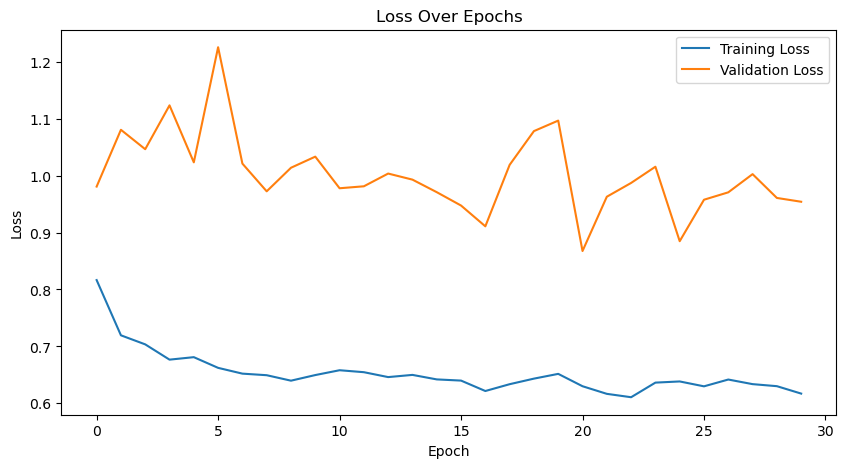

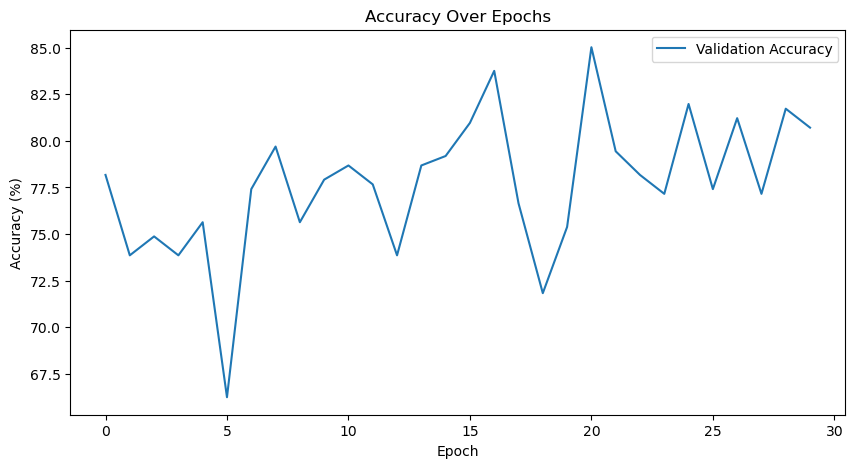

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


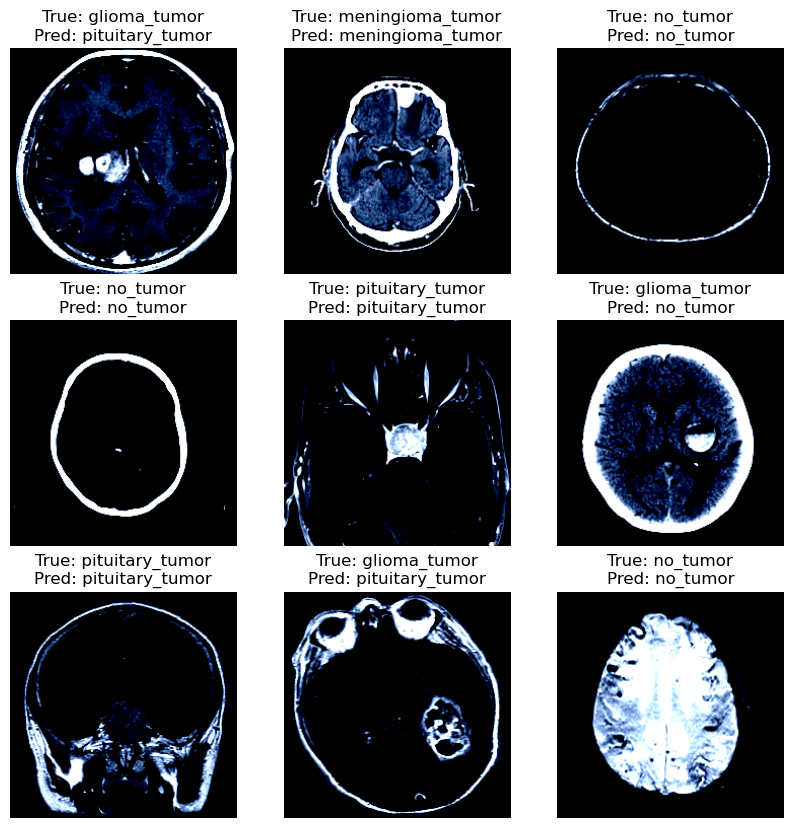

In [12]:
# Function to display predictions
def display_predictions(model, dataset, classes):
    model.eval()
    fig = plt.figure(figsize=(10, 10))
    rows, cols = 3, 3
    for i in range(1, rows * cols + 1):
        idx = torch.randint(0, len(dataset), size=(1,)).item()
        image, label = dataset[idx]
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            _, predicted = torch.max(output, 1)
        ax = fig.add_subplot(rows, cols, i)
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f"True: {classes[label]}\nPred: {classes[predicted.item()]}")
        ax.axis('off')
    plt.show()

# Display predictions on test dataset
display_predictions(model, test_dataset, classes)


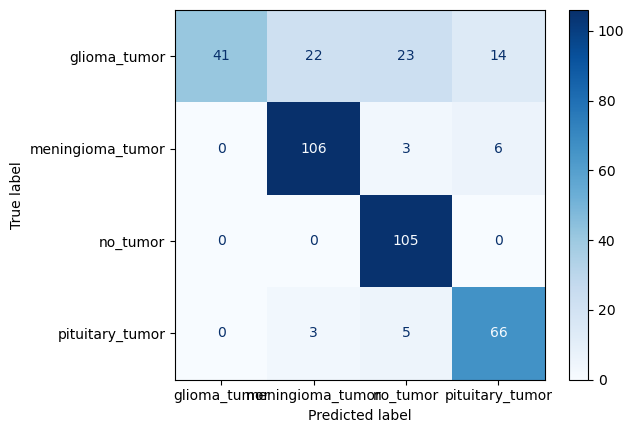

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions and true labels
model.eval()
y_preds = []
y_true = []
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        outputs = model(X)
        _, preds = torch.max(outputs, 1)
        y_preds.extend(preds.cpu().numpy())
        y_true.extend(y.numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()
